# Backend Execution of Pulser Sequences

When the time comes to execute a Pulser sequence, there are many options: one can choose to execute it on a QPU or on an emulator, which might happen locally or remotely. All these options are accessible through an unified interface we call a `Backend`. 

This tutorial is a step-by-step guide on how to use the different backends for Pulser sequence execution.

## 1. Choosing the type of backend

Although the backend interface nearly doesn't change between backends, some will unavoidably enforce more restrictions on the sequence being executed or require extra steps. In particular, there are two questions to answer:

1. **Is it local or remote?** Execution on remote backends requires a working remote connection. For now, this is only available through `pulser_pasqal.PasqalCloud`.
2. **Is it a QPU or an Emulator?** For QPU execution, there are extra constraints on the sequence to take into account.

### 1.1. Starting a remote connection

For remote backend execution, start by ensuring that you have access and start a remote connection. For `PasqalCloud`, we could start one by running:

In [2]:
from pulser_pasqal import PasqalCloud

connection = PasqalCloud(
    username=USERNAME,  # Your username or email address for the Pasqal Cloud Platform
    project_id=PROJECT_ID,  # The ID of the project associated to your account
    password=PASSWORD,  # The password for your Pasqal Cloud Platform account
    **kwargs
)

### 1.2. Preparation for execution on  `QPUBackend`

Sequence execution on a QPU is done through the `QPUBackend`, which is a remote backend. Therefore, it requires a remote backend connection, which should be open from the start due to two additional QPU constraints:

1. The `Device` must be chosen among the options available at the moment, which can be found through `connection.fetch_available_devices()`.
2. The `Register` must be defined from one of the register layouts calibrated for the chosen `Device`, which are found under `Device.calibrated_register_layouts`. Check out [this tutorial](reg_layouts.nblink) for more information on how to define a `Register` from a `RegisterLayout`.

On the contrary, execution on emulator backends imposes no further restriction on the device and the register. We will stick to emulator backends in this tutorial, so we will forego the requirements of QPU backends in the following steps.

## 2. Creating the Pulse Sequence

The next step is to create the sequence that we want to execute. Here, we make a sequence with a variable duration combining a Blackman waveform in amplitude and a ramp in detuning. Since it will be executed on an emulator, we can create the register we want and choose a `VirtualDevice` that does not impose hardware restrictions (like the `MockDevice`).

In [3]:
import numpy as np

from pulser import Sequence, Pulse, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform

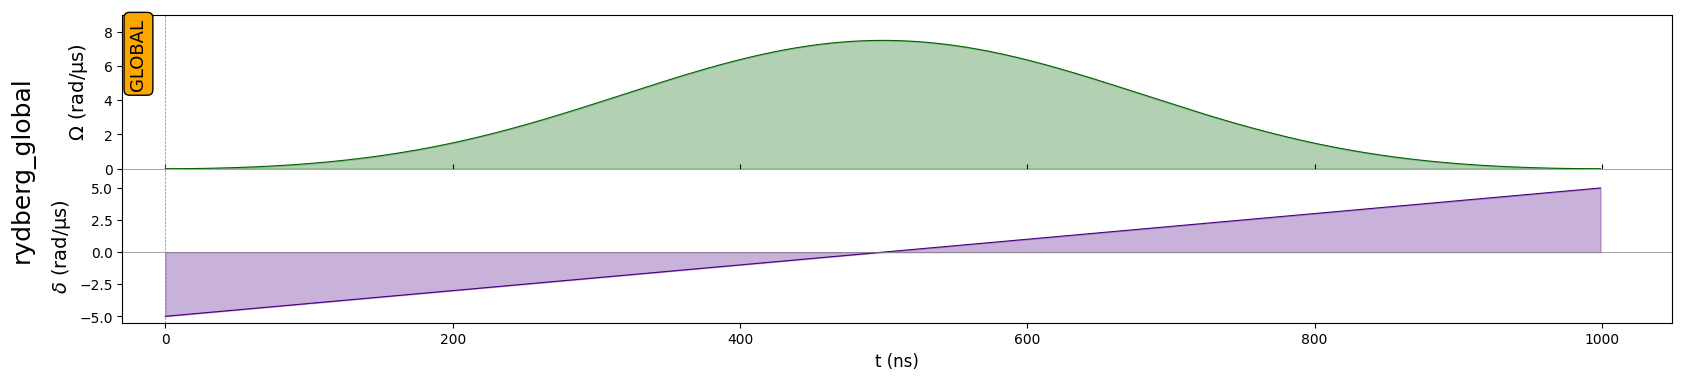

In [4]:
reg = Register({"q0": (-5, 0), "q1": (5, 0)})

seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")
t = seq.declare_variable("t", dtype=int)

amp_wf = BlackmanWaveform(t, np.pi)
det_wf = RampWaveform(t, -5, 5)
seq.add(Pulse(amp_wf, det_wf, 0), "rydberg_global")

# We build with t=1000 so that we can draw it
seq.build(t=1000).draw()

## 3. Starting the backend

It is now time to select and initialize the backend. Currently, these are the available backends (but bear in mind that the list may grow in the future):

 - **Local**: 
     - `QutipBackend` (from `pulser_simulation`): Uses `QutipEmulator` to emulate the sequence execution locally.
 - **Remote**:
     - `QPUBackend` (from `pulser`): Executes on a QPU through a remote connection.
     - `EmuFreeBackend` (from `pulser_pasqal`): Emulates the sequence execution using free Hamiltonian time evolution (similar to `QutipBackend`, but runs remotely). 
     - `EmuTNBackend` (from `pulser_pasqal`): Emulates the sequence execution using a tensor network simulator.

Instead of choosing one, here we will import the three emulator backends so that we can compare them.

In [5]:
from pulser_simulation import QutipBackend
from pulser_pasqal import EmuFreeBackend, EmuTNBackend

Upon creation, all backends require the sequence they will execute. Emulator backends also accept, optionally, a configuration given as an instance of the `EmulatorConfig` class. This class allows for setting all the parameters available in `QutipEmulator` and is forward looking, meaning that it envisions that these options will at some point be availabe on other emulator backends. This also means that trying to change parameters in the configuration of a backend that does not support them yet will raise an error.

Even so, `EmulatorConfig` also has a dedicated `backend_options` for options specific to each backend, which are detailed in the [backends' docstrings](../apidoc/backend.rst).

In [6]:
from pulser.backend import EmulatorConfig

With `QutipBackend`, we have free reign over the configuration. In this example, we will:
 
- Change the `sampling_rate`
- Include measurement errors using a custom `NoiseModel`

On the other hand, `QutipBackend` does not support parametrized sequences. Since it is running locally, they can always be built externally before being given to the backend. Therefore, we will build the sequence (with `t=2000`) before we give it to the backend.

In [7]:
from pulser.backend import NoiseModel

config = EmulatorConfig(
    sampling_rate=0.1,
    noise_model=NoiseModel(
        noise_types=("SPAM",),
        p_false_pos=0.01,
        p_false_neg=0.004,
        state_prep_error=0.0,
    ),
)

qutip_bknd = QutipBackend(seq.build(t=2000), config=config)

Currently, the remote emulator backends are still quite limited in the number of parameters they allow to be changed. Furthermore, the default configuration of a given backend does not necessarily match that of `EmulatorConfig()`, so it's important to start from the correct default configuration. Here's how to do that for the `EmuTNBackend`:

In [8]:
from dataclasses import replace

emu_tn_default = EmuTNBackend.default_config
# This will create a new config with a different sampling rate
# All other parameters remain the same
emu_tn_config = replace(emu_tn_default, sampling_rate=0.5)

We will stick to the default configuration for `EmuFreeBackend`, but the process to create a custom configuration would be identical. To know which parameters can be changed, consult the backend's docstring.

In [9]:
free_bknd = EmuFreeBackend(seq, connection=connection)
tn_bknd = EmuTNBackend(seq, connection=connection, config=emu_tn_config)

Note also that how the remote backends require an open connection upon initialization. This would also be the case for `QPUBackend`.

## 4. Executing the Sequence

Once the backend is created, executing the sequence is always done through the backend's `run()` method.

For the `QutipBackend`, all arguments are optional and are the same as the ones in `QutipEmulator`. On the other hand, remote backends all require `job_params` to be specified. `job_params` are given as a list of dictionaries, each containing the number of runs and the values for the variables of the parametrized sequence (if any). The sequence is then executed with the parameters specified within each entry of `job_params`.

In [10]:
# Local execution, returns the same results as QutipEmulator
qutip_results = qutip_bknd.run()

# Remote execution, requires job_params
job_params = [
    {"runs": 100, "variables": {"t": 1000}},
    {"runs": 50, "variables": {"t": 2000}},
]
free_results = free_bknd.run(job_params=job_params)
tn_results = tn_bknd.run(job_params=job_params)

## 5. Retrieving the Results

For the `QutipBackend` the results are identical to those of `QutipEmulator`: a sequence of individual `QutipResult` objects, one for each evaluation time. As usual we can, for example, get the final state:

In [11]:
qutip_results[-1].state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.38024396-0.15656328j]
 [ 0.03529282+0.59329452j]
 [ 0.03529282+0.59329452j]
 [-0.23481812-0.26320141j]]

For remote backends, the object returned is a `RemoteResults` instance, which uses the connection to fetch the results once they are ready. To check the status of the submission, we can run:

In [12]:
free_results.get_status()

<SubmissionStatus.DONE: 3>

When the submission states shows as `DONE`, the results can be accessed. In this case, they are a sequence of `SampledResult` objects, one for each entry in `job_params` in the same order. For example, we can retrieve the bitstring counts or even plot an histogram with the results:

{'00': 5, '01': 13, '10': 26, '11': 56}


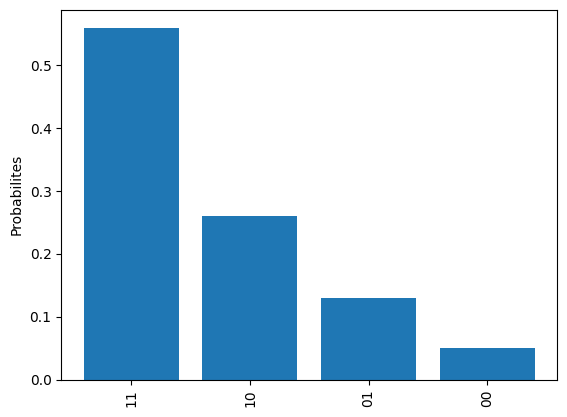

In [13]:
print(free_results[0].bitstring_counts)
free_results[0].plot_histogram()

The same could be done with the results from `EmuTNBackend` or even from `QPUBackend`, as they all share the same format.